# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [41]:
# Import libraries
import torch
import torch.nn.functional as F
import json
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from collections import OrderedDict

import numpy as np

from PIL import Image

# Workspace utils
import workspace-utils

# Debug
import matplotlib.pyplot as plt
from datetime import datetime

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
#---
# GET DATA
#---

data_dir = 'flowers'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir + '/valid'

In [4]:
# Defined of transforms for the training, validation and testing sets
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Load the datasets with ImageFolder for train set
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Defined the dataloaders, using the image datasets and the trainforms
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

DEBUG: image size:  torch.Size([64, 3, 224, 224])


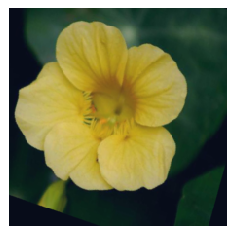

In [5]:
# DEBUG: check image shape
images, labels = next(iter(train_loader))
print("DEBUG: image size: ", images.shape)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
# Load classes classifier will use
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
# DEBUG: check json file
print("DEBUG: json file: \n", cat_to_name, "\n\n")
print("DEBUG: Count json file items (number of output): ", len(cat_to_name))

DEBUG: json file: 
 {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pock

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
#---
# GET MODEL
#---

# Load pre-trained network model
model = models.vgg16(pretrained=True)

In [9]:
# DEBUG: check model
print("DEBUG: Current model: \n", model)

DEBUG: Current model: 
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [10]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Build neural network classifier
"""
Rule of thumb during building neural network:
* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.
"""
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(25088,6272)  # First layer as input get 25088 pixels
        self.fc2 = nn.Linear(6272,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,102)  # Output layer give as output 102 classes with probabilities for each
        
        # Dropout model with 0.2 drop probability
		self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, x):
        # Make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))  # First layer activation function is ReLU (is quick) with droput
        x = self.dropout(F.relu(self.fc2(x)))  # Second layer activation function is ReLU (is quick) with dropout
        x = self.dropout(F.relu(self.fc3(x)))  # Third  layer activation function is ReLU (is quick) with dropout
        
        # Outout so no dropout
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [12]:
#---
# INIT MODEL
#---

# Replace model classifier
model.classifier = Classifier()

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setup loss function
criterion = nn.NLLLoss()

# Setup optimizer. Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [14]:
# DEBUG: check device
print("DEBUG: Current device: ", device)

DEBUG: Current device:  cuda


In [15]:
#---
# MODEL LEARNIG PROCESS
#---
# How many times we repeat the process
epochs = 1
steps = 0
running_loss = 0
print_every = 5
train_losses = []
valid_losses = []

# Training loop
with workspace-utils.active_session():
    for epoch in range(epochs):
        # For each image in data set, train neural network model
        for inputs, labels in train_loader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Calculating predicted output
            output = model.forward(inputs)
            # Calculating loss
            loss = criterion(output, labels)
            
            # Training pass
            optimizer.zero_grad()
            # Calculating backpropagation based on loss
            loss.backward()
            # Update weights and biases
            optimizer.step()

            # Calculating loss for epoch
            running_loss += loss.item()
            
            # For each print_every (deaful 5) images calculate validation
            if steps % print_every == 0:
                # Initiate value of loss for each print_every (deaful 5) image 
                running_loss = 0                
                # Initiate value of test loss after each epoch
                valid_loss = 0
                # Initiate value of accuracy after each epoch
                accuracy = 0
                # Turn off gradients for validation to save memory and computations                                
                with torch.no_grad():
                    # Turn on model evaluation mode to turn off dropout
                    model.eval()
                    for inputs, labels in valid_loader:
                        # Move input and label tensors to the default device
                        inputs, labels = inputs.to(device), labels.to(device)
                        # Calculating test predicted output
                        output = model.forward(inputs)
                        # Calculating loss
                        batch_loss = criterion(output, labels)                        

                    # Calculate accuracy
                        # Get class probability
                        output_class_probability = torch.exp(output)
                        # Get top highest values of probability for classes
                        top_p, top_class = output_class_probability.topk(1, dim=1)
                        # Calculate if classes are correct
                        equals = top_class == labels.view(*top_class.shape)
                        # Calculating accuracy
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                        
                        # Calculating test loss for epoch
                        valid_loss += batch_loss.item()
                # Turn off evaluation mode and turn on training mode aka tunr on dropout
                model.train()
                
                # Add train loss for epoch
                train_losses.append(running_loss/len(train_loader))
                # Add validation loss for epoch
                valid_losses.append(valid_loss/len(valid_loader))
                
                # Print recaption after epoch
                step_time = datetime.now().strftime("%H:%M:%S")                
                print(f"{step_time}: "
                      f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f} ; "
                      f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
                
    print("DEBUG: Training is done.")

00:32:56: Epoch 1/1.. Train loss: 8.823 ; Validation loss: 4.756.. Validation accuracy: 0.010
00:33:22: Epoch 1/1.. Train loss: 4.683 ; Validation loss: 4.563.. Validation accuracy: 0.035
00:33:48: Epoch 1/1.. Train loss: 4.560 ; Validation loss: 4.534.. Validation accuracy: 0.041
00:34:15: Epoch 1/1.. Train loss: 4.466 ; Validation loss: 4.428.. Validation accuracy: 0.079
00:34:41: Epoch 1/1.. Train loss: 4.427 ; Validation loss: 4.293.. Validation accuracy: 0.111
00:35:08: Epoch 1/1.. Train loss: 4.276 ; Validation loss: 4.151.. Validation accuracy: 0.131
00:35:35: Epoch 1/1.. Train loss: 4.040 ; Validation loss: 3.895.. Validation accuracy: 0.135
00:36:01: Epoch 1/1.. Train loss: 3.951 ; Validation loss: 3.579.. Validation accuracy: 0.179
00:36:28: Epoch 1/1.. Train loss: 3.658 ; Validation loss: 3.341.. Validation accuracy: 0.194
00:36:54: Epoch 1/1.. Train loss: 3.325 ; Validation loss: 3.367.. Validation accuracy: 0.237
00:37:21: Epoch 1/1.. Train loss: 3.252 ; Validation loss: 2

In [ ]:
# DEBUG: check loss daiagrams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
#---
# MODEL TEST VALIDATION
#---
with active_session():
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            log_ps = model.forward(inputs)
            batch_loss = criterion(log_ps, labels)

            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Test accuracy: {accuracy/len(test_loader):.3f}")
    print("DEBUG: Validation on test set done.")
    model.train()

Test accuracy: 0.004
Test accuracy: 0.022
Test accuracy: 0.032
Test accuracy: 0.049
Test accuracy: 0.065
Test accuracy: 0.077
Test accuracy: 0.088
Test accuracy: 0.097
Test accuracy: 0.129
Test accuracy: 0.160
Test accuracy: 0.174
Test accuracy: 0.190
Test accuracy: 0.216
Test accuracy: 0.239
Test accuracy: 0.260
Test accuracy: 0.284
Test accuracy: 0.304
Test accuracy: 0.340
Test accuracy: 0.370
Test accuracy: 0.397
Test accuracy: 0.411
Test accuracy: 0.418
Test accuracy: 0.434
Test accuracy: 0.439
Test accuracy: 0.463
Test accuracy: 0.467
DEBUG: Validation on test set done.


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [33]:
# Save the checkpoint 
model.class_to_idx = train_dataset.class_to_idx

# Define checkpoint with parameters to be saved
checkpoint = {'input_size': 25088,
              'output_size': 102, 
              'classifier': model.classifier,
              'optimizer': optimizer,
              'optimizer_state': optimizer.state_dict(),
              'arch': "vgg16",
              'class_to_idx': model.class_to_idx,               
              'model_state_dict': model.state_dict()}

#Save checkpoint
torch.save(checkpoint,'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [34]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    # Solve problem switching between cuda and cpu device
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
    
    # Load checkpoint dict
    checkpoint = torch.load(filepath, map_location=map_location)
    
    # Load model
    if checkpoint['arch'] == 'vgg16':
        model = models.vgg16(pretrained = True)
        
        for param in model.parameters():
            param.requires_grad = False
        
        model.class_to_idx = checkpoint['class_to_idx']
        model.classifier = checkpoint['classifier']
        model.load_state_dict(checkpoint['model_state_dict'])
        
    return model
    
model = load_checkpoint('checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [35]:
# Process a PIL image for use in a PyTorch model
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array.
        
        Algorithm:
        image = tf.convert_to_tensor(image)
        image = function to resize image
        image = rehsape the image
        image = image.numpy()
    '''    
    print("DEBUG: Passed value contain: ", image_path)

    image = Image.open(image_path)
    image_transform = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.485, 0.456, 0.406],
                                              [0.229, 0.224, 0.225])])
    image = image_transform(image)
    print("DEBUG: Check image shape: ", image.shape)
#     image = image.numpy()

    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [36]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [37]:
# Predict the class from an image file
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''
    image = process_image(image_path)
    image.unsqueeze_(0)
    top_p, top_class = torch.exp(model.forward(image)).topk(top_k, dim=1)
    
    # OPTIONAL: str_ind = change the indices to map them to class names
    
    return top_p[0], top_class[0]

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [1]:
# Display an image along with the top 5 classes
image = process_image('./flowers/train/1/image_06734.jpg')
imshow(image)

NameError: name 'imshow' is not defined

In [ ]:
# Display the top 5 classes with their probabilities
top_p, top_class = predict('./flowers/train/1/image_06734.jpg', model)

index = 0
for elem in top_class:
    print(f"Flower: {cat_to_name[str(int(elem))]} : {top_p[index]*100:.0f}%")
    index += 1